In [2]:
# numerics
import numpy as np
import math as m
import scipy
from scipy.fftpack import fft,ifft,fftshift,fft2
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy import signal
pi = m.pi

# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.gridspec import GridSpec
from matplotlib.patches import FancyArrowPatch, ArrowStyle
import matplotlib.patches as patches
from wav_analysis.add_cb import add_color_bar_V
from cmap import purula

# others
import os
import happi
import h5py

plt.style.use("paper")

In [3]:
# basic parameters
me = 1.
e = 1.
mp = 100 * me
c = 1
# -> wpe = 1

wpp = 1./np.sqrt(mp)  # proton plasma frequency
v_ratio = 15.         # c/vA
wcp = wpp/v_ratio     # cyclotron frequency
B0 = wcp*mp/e         # magnetic field magnitude

vA = c/v_ratio        # proton Afven speed
vbth = 0.03*vA        # background proton thermal velocity
vsth = 0.45*vA        # shell dist. proton thermal velocity
dt = 0.001            # simualtion time step, in wcp^-1

#使用初始背景磁场的大小来初步验证模拟结果
init_Bx = B0                     # B0 is on x axis
lambda_p = c/wpp             # characteristc length (proton inertial length)

# simulation length & grid 
Lx = 102.4*lambda_p         
Ly = 12.8*lambda_p
Nx = 512
Ny = 128
dx = Lx/Nx
dy = Ly/Ny

#setting grid
#空间上的单位是lambda_i
dx_norm = dx/lambda_p
dy_norm = dy/lambda_p
x = np.linspace(0,Nx,Nx+1)
y = np.linspace(0,Ny,Ny+1)

X,Y = np.meshgrid(x.astype(int),y.astype(int))


# integrate 
init_UB = 0.5 * init_Bx**2 * dx * dy * (Nx+1) * (Ny+2)

wcp_unit = '$\Omega_{cp}$'

In [4]:
filename = '20ns'
with h5py.File('./data/' + filename + '_scalar.h5', 'r') as f:
    # 列出所有 dataset
    print(list(f.keys()))
    field0_t = f['field0_t'][:]
    scalar_t = f['scalar_t'][:]
    binning_t = f['binning_t'][:]
    UBx = f['UBx'][:]
    UBy = f['UBy'][:]
    UBz = f['UBz'][:]
    UEx = f['UEx'][:]
    UEy = f['UEy'][:]
    UEz = f['UEz'][:]
    Utot = f['Utot'][:]
    Ukin_cold_ion = f['Ukin_cold_ion'][:]
    Ukin_shell_ion = f['Ukin_shell_ion'][:]
    A_c = f['A_c'][:]
    Tpa_c = f['Tpa_c'][:]
    Tpe_c = f['Tpe_c'][:]

init_U = Utot[0]

['A_c', 'Tpa_c', 'Tpe_c', 'UBx', 'UBy', 'UBz', 'UEx', 'UEy', 'UEz', 'Ukin_cold_ion', 'Ukin_shell_ion', 'Utot', 'binning_t', 'field0_t', 'scalar_t']


In [5]:
print(field0_t.shape)
print(UBx.shape)
print(UBy.shape)

(9000,)
(9000,)
(900,)


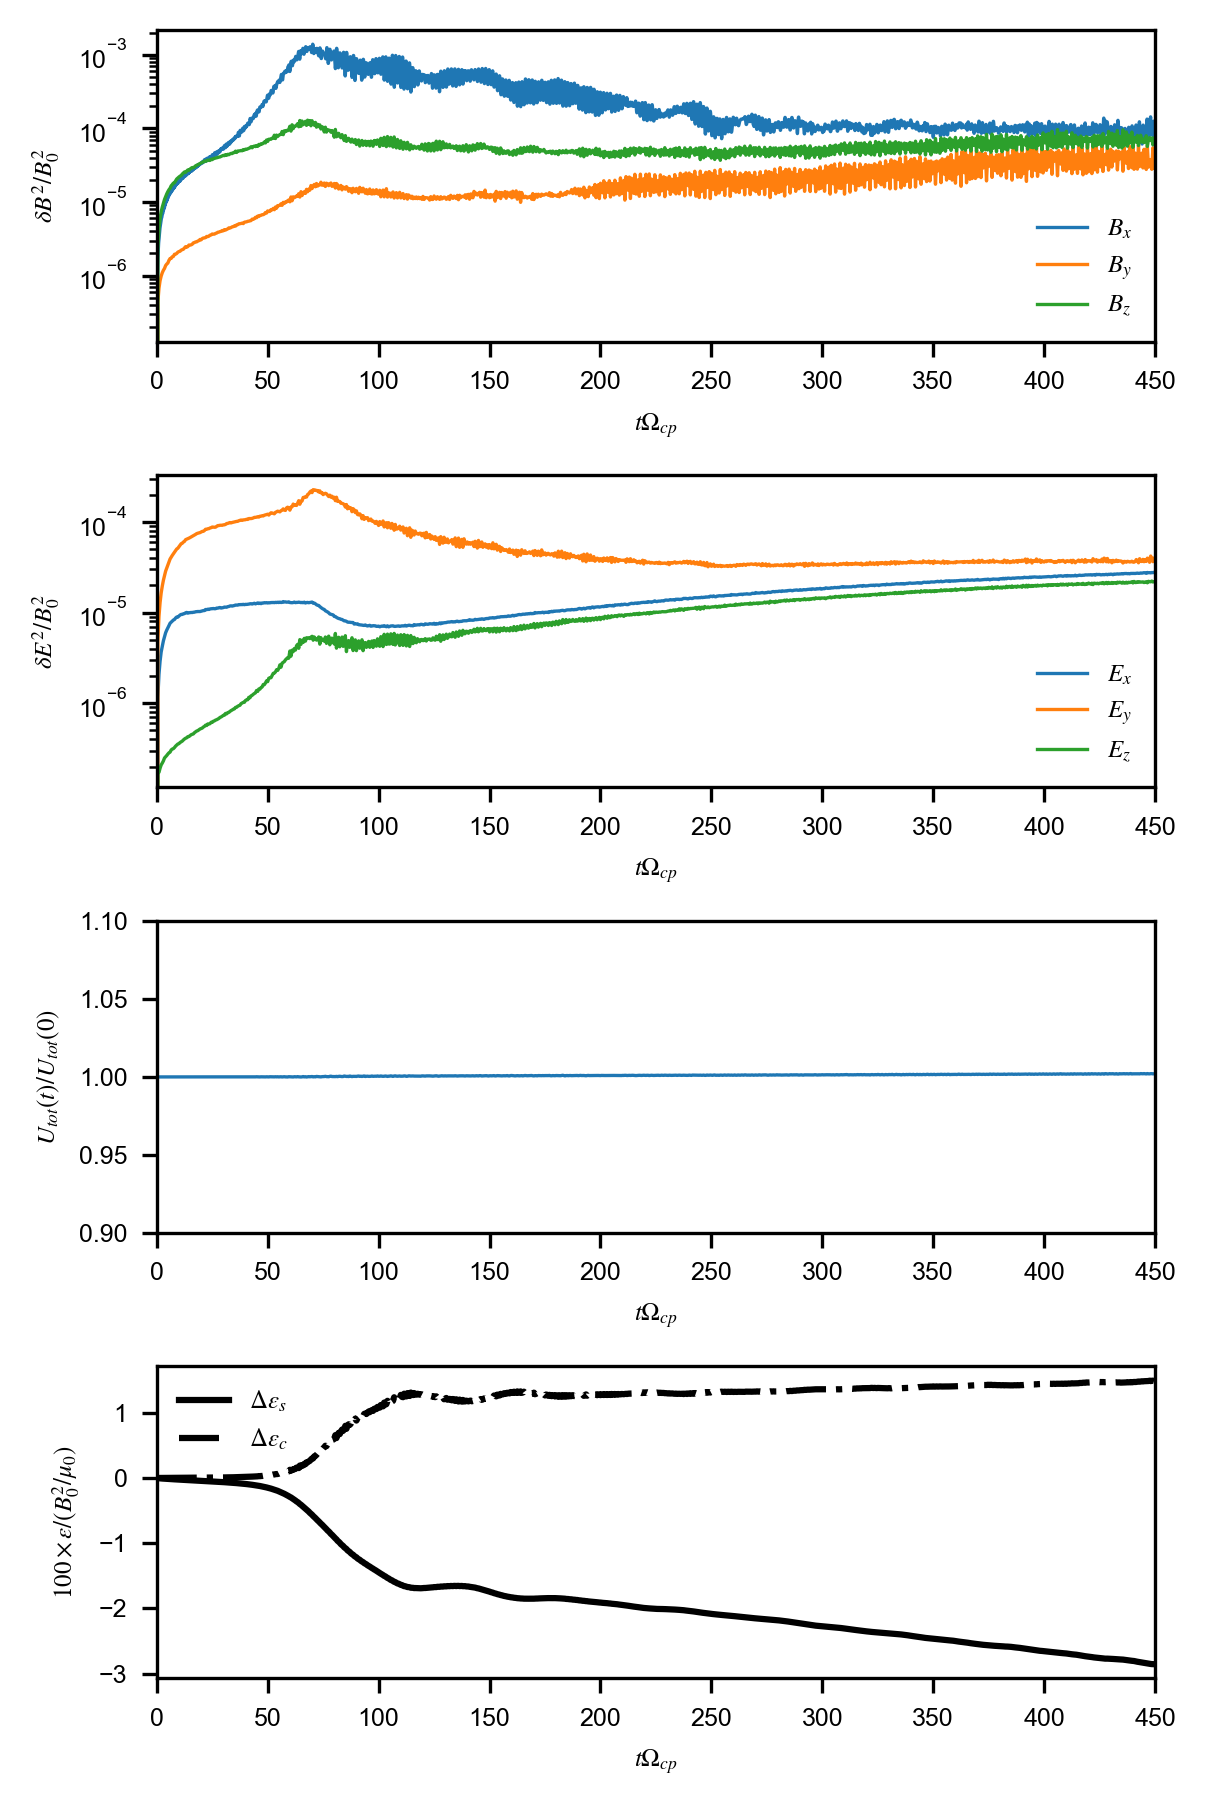

In [16]:
t_snapshot = 450
plt.close()
fig,axs=plt.subplots(4,1,figsize=[4,6])
axs[0].plot(field0_t*wcp,UBx,lw=0.8,label='$B_x$')
axs[0].plot(scalar_t*wcp,UBy,lw=0.8,label='$B_y$')
axs[0].plot(scalar_t*wcp,UBz,lw=0.8,label='$B_z$')
axs[0].set_yscale('log')
axs[0].set_xlim(0, t_snapshot)
axs[0].set_xlabel('$t$'+wcp_unit)
axs[0].set_ylabel('$\delta B^2/B_0^2$')
axs[0].legend()


axs[1].plot(scalar_t*wcp,UEx,lw=0.8,label='$E_x$')
axs[1].plot(scalar_t*wcp,UEy,lw=0.8,label='$E_y$')
axs[1].plot(scalar_t*wcp,UEz,lw=0.8,label='$E_z$')
axs[1].set_yscale('log')
axs[1].set_xlim(0, t_snapshot)
axs[1].set_xlabel('$t$'+wcp_unit)
axs[1].set_ylabel('$\delta E^2/B_0^2$')
axs[1].legend()

axs[2].plot(scalar_t*wcp,Utot/init_U,lw=0.8)
axs[2].set_xlim(0, t_snapshot)
axs[2].set_ylim(0.9,1.1)
axs[2].set_xlabel('$t$'+wcp_unit)
axs[2].set_ylabel('$U_{tot}(t)/U_{tot}(0)$')


axs[3].plot(scalar_t*wcp, 100*(Ukin_shell_ion-Ukin_shell_ion[0])/init_UB, color='black',lw=1.5,label='$\Delta \epsilon_{s}$')
axs[3].plot(scalar_t*wcp, 100*(Ukin_cold_ion-Ukin_cold_ion[0])/init_UB, color='black',lw=1.5,linestyle= '-.',label='$\Delta \epsilon_{c}$')
axs[3].set_xlim(0, t_snapshot)
axs[3].set_xlabel('$t$'+wcp_unit)
axs[3].set_ylabel(r'$100 \times \epsilon/(B_0^2/ \mu_0)$')
axs[3].legend()

plt.tight_layout()

# 保存高分辨率图像
plt.savefig("./picture/B&E_wave_energy.pdf", dpi=400, bbox_inches='tight')
plt.show()

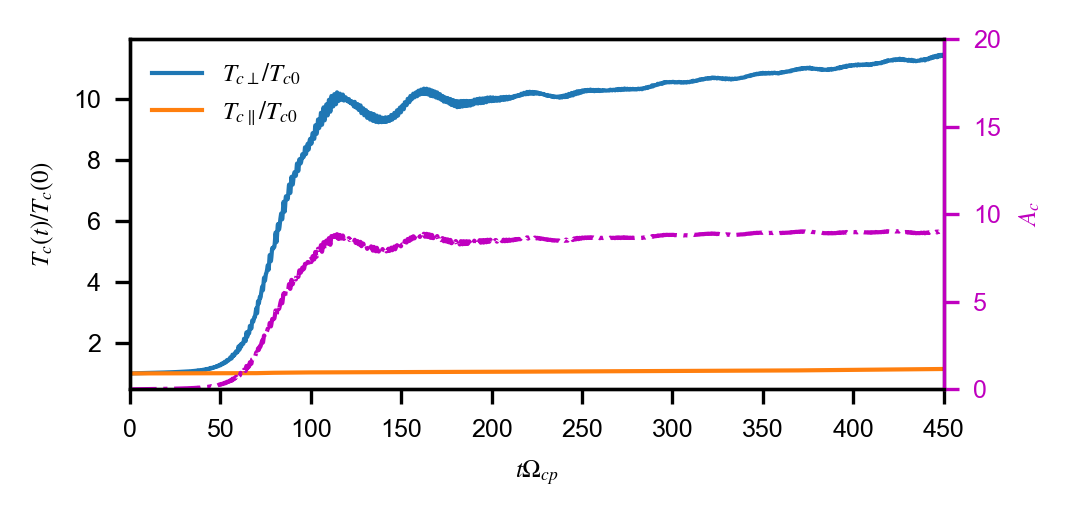

In [7]:
plt.close()
fig,ax = plt.subplots(figsize=[3.5,1.6])
ax.plot(binning_t*wcp,Tpe_c,label=r"$T_{c \perp}/T_{c0}$")
ax.plot(binning_t*wcp,Tpa_c,label=r"$T_{c \parallel}/T_{c0}$")
ax.set_ylabel('$T_c(t)/T_c(0)$')
tx = ax.twinx()
tx.plot(binning_t*wcp,A_c,c='m',ls='-.')
tx.set_ylabel('$A_c$',color='m')
tx.set_ylim(0,20)
tx.tick_params(axis='y',colors='m')
tx.spines['right'].set_color('m')
ax.legend(loc=2)

ax.set_xlabel('$t$'+wcp_unit)
ax.set_xlim(0,t_snapshot)

# 保存高分辨率图像
plt.savefig("./picture/temperature.pdf", dpi=400, bbox_inches='tight')